In [1]:
# import relevant libraries
import numpy as np
import re
import glob
import os
import pathlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import datetime
from impactClass import impactClass
%matplotlib inline

In [2]:
# define method to load data from files
def loadSegmentFile(filename):
    file = open(filename, mode = 'r')
    lines = file.readlines()
    file.close()
    N = len(lines)
    gps = np.zeros([N,1])
    dur = np.zeros([N,1])
    for ii in range(0,N):
        base = os.path.basename(lines[ii])
        x = re.findall(r'g_(\d+)_(\d+).tar.gz\n',base)
        y = x.pop(0)
        gps[ii] = float(y[0])
        dur[ii] = float(y[1])
    out = {'gps' : gps, 'dur' : dur}
    return out

# define method to find large chunks
def getPlotSegs(segs,thresh=86400):
    gps = segs['gps']
    dur = segs['dur']
    gaps = np.zeros([len(gps),1])
    for ii in range(0,len(gps)-1):
        start = gps[ii]
        stop = gps[ii]+dur[ii]
        gaps[ii] = gps[ii+1]-stop
        
    bigIdx = np.where(gaps > thresh)[0]
    bigStarts = gps[np.append(0,bigIdx+1)]
    bigStops = gps[np.append(bigIdx,len(gaps)-1)]+dur[np.append(bigIdx,len(gaps)-1)]
    bigDurs = bigStops-bigStarts
    out = {'starts' : bigStarts, 'stops' : bigStops, 'length' : bigDurs, 'idx' : np.append(0,bigIdx+1)}
    return out

# make patch rectangles
def makePatches(segs,facecolor = 'r',yrange = (0,1),thresh=86400):
    # find big segments
    bigSegs = getPlotSegs(segs,thresh)
    
    # Create list for all the error patches
    boxes = []

    # Loop over data points; create box from errors at each point
    st = bigSegs['starts']
    ln = bigSegs['length']
    for ii in range(0,len(st)):
        rect = Rectangle((st[ii], yrange[0]), ln[ii], yrange[1])
        boxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(boxes, facecolor=facecolor,edgecolor='None', alpha=1.0)
    
    # return patches
    return pc

In [55]:
# load segment data
p = pathlib.PurePath(os.getcwd())
BASE_DIR = str(p.parent)
dataDir = '/data'
plotDir = '/plots'
drs = loadSegmentFile(BASE_DIR + dataDir + '/observed_times/DRSlistDec.txt')
ltp = loadSegmentFile(BASE_DIR + dataDir + '/observed_times/LTPlist2.txt')
hybrid = loadSegmentFile(BASE_DIR + dataDir + '/observed_times/LTPCMNTlist.txt')


In [4]:
# load impact data
impFiles = glob.glob(BASE_DIR + dataDir + '/ONLY_IMPACTS/*_grs1.pickle')
imps = []
for idx,impFile in enumerate(impFiles):
    imp = impactClass(impFile, dataDir = dataDir, BASE_DIR = BASE_DIR)
    if imp.isImpact :
        imp.SCtoSun()
        imp.findSkyAngles()
        imps.append(imp)

print('%d impacts loaded' % len(imps))


54 impacts loaded


In [5]:
gps = np.zeros((len(imps),1))
P = np.zeros((len(imps),1))
for ii in range(0,len(imps)):
    gps[ii] = imps[ii].gps
    P[ii] = np.median(imps[ii].Ptot)

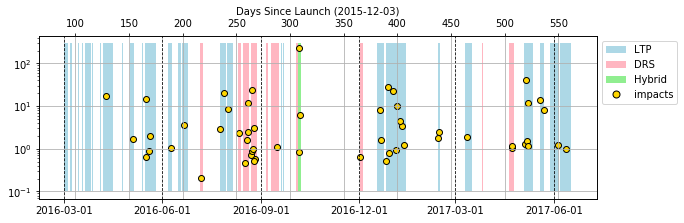

In [58]:
fig,ax = plt.subplots(1)

pcDRS = makePatches(drs,'lightpink',(1e-1,3e2))
pcLTP = makePatches(ltp,'lightblue',(1e-1,3e2))
pcHybrid = makePatches(hybrid,'lightgreen',(1e-1,3e2))

# Add collection to axes
ax.add_collection(pcLTP)
ax.add_collection(pcDRS)
ax.add_collection(pcHybrid)

ax.scatter(gps,P,facecolor='gold',edgecolor='black')
ax.set_yscale('log')
ax.yaxis.grid(True)
ax2 = ax.twiny()

xlabs = ('2016-03-01','2016-06-01','2016-09-01','2016-12-01','2017-03-01','2017-06-01')
xlocs = np.zeros((len(xlabs),1))
for ii in range(0,len(xlocs)):
    xlocs[ii]= (datetime.datetime.strptime(xlabs[ii],'%Y-%m-%d')-datetime.datetime(1970,1,1)).total_seconds()
    xlocs[ii]=xlocs[ii]-315964783

ax.set_xticks(xlocs)
ax.set_xticklabels(xlabs,rotation=0)
ax.xaxis.grid(True,linestyle='--',color='black')
axlim = ax.get_xlim()
plt.ylabel('$P\,[\mu Ns]$')


t0 = ((datetime.datetime.strptime('2015-12-03','%Y-%m-%d')-datetime.datetime(1970,1,1)).total_seconds())-315964783
xlabs = (100,150,200,250,300,350,400,450,500,550)
xlocs = np.zeros((len(xlabs),1))
for ii in range(0,len(xlocs)):
    xlocs[ii]= t0+xlabs[ii]*86400
    
ax2.set_xlim(axlim)
ax2.xaxis.tick_top()
ax2.set_xticks(xlocs)
ax2.set_xticklabels(xlabs)
ax2.set_xlabel('Days Since Launch (2015-12-03)')
ax2.xaxis.grid(True)

#plt.xticks(xlocs,xlabs)
fig.set_size_inches(10,3)


handles = []
handles.append(Polygon([(0,0),(10,0),(0,-10)],facecolor='lightblue',label='LTP'))
handles.append(Polygon([(0,0),(10,0),(0,-10)],facecolor='lightpink',label='DRS'))
handles.append(Polygon([(0,0),(10,0),(0,-10)],facecolor='lightgreen',label='Hybrid'))
handles.append(mlines.Line2D([], [], linestyle='none', markerfacecolor='gold', markeredgecolor = 'black',marker='o',markersize=7, label='impacts'))
#handles.append(Circle((0,0),facecolor='gold',edgecolor = 'black',label='impacts'))
plt.legend(handles = handles, loc = 'upper left',bbox_to_anchor=(1,1))
plt.show()

fig.savefig(BASE_DIR + plotDir + '/timeline.eps', format = 'eps',bbox_inches='tight')